In [1]:
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage, maf_limit = 0.01, use_hwe = False):
    # Predixcan style filtering of snps
    newsnps = list()
    newdosage = list()
    npoly = 0
    nambi = 0
    nunkn = 0
    nlowf = 0
    nlowf_actual = 0
    nhwep = 0
    nalle = 0
    for i, snp in enumerate(snpinfo):
        pos = snp.bp_pos
        refAllele = snp.ref_allele
        effectAllele = snp.alt_allele
        rsid = snp.varid
        maf = round(snp.maf, 3)
        # Actual MAF is lower / higher than population MAF because some samples have been removed
        maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
        # Skip non-single letter polymorphisms
        if len(refAllele) > 1 or len(effectAllele) > 1:
            npoly += 1
            continue
        # Skip unknown alleles
        if refAllele not in SNP_COMPLEMENT or effectAllele not in SNP_COMPLEMENT:
            nalle += 1
            continue
        # Skip ambiguous strands
        if SNP_COMPLEMENT[refAllele] == effectAllele:
            nambi += 1
            continue
        # Skip unknown RSIDs
        if rsid == '.':
            nunkn += 1
            continue
        # Skip low MAF
        if not (maf >= maf_limit and maf <= (1 - maf_limit)):
            nlowf += 1
            continue
        # Skip low actual MAF
        if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
            nlowf_actual += 1
            continue
        # Check HWE
        if use_hwe:
            # Convert to integers 0, 1 or 2
            bins = [0.66, 1.33]
            intdosage = np.digitize(dosage[i], bins)
            # Remove SNPs out of HWE
            hwep = HWEcheck(intdosage)
            if(hwep < 0.000001):
                nhwep += 1
                # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
                continue
        new_snp = snp._replace(maf = maf_actual)
        newsnps.append(new_snp)
        newdosage.append(dosage[i])
    print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
    print("Removed {:d} SNPs because of unknown allele symbol".format(nalle))
    print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
    print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
    print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
    print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
    if use_hwe: print("Removed {:d} SNPs because of deviation from HWE".format(nhwep))
    return newsnps, np.array(newdosage)  

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]
                    
                    # change to minor allele freq
                    # if maf > 0.5:
                    #     snpdosage = [2.0-s for s in snpdosage]
                    #     ref, alt = alt, ref
                    #     maf = 1 - maf
                    
                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)]
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def knn_correction(expr, dosage, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

In [3]:
gencode_file = "/cbscratch/franco/datasets/FHS/probe_annotations.affy"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

In [38]:
# Load real expression
import pandas as pd
# df = pd.read_csv("/cbscratch/franco/datasets/FHS/expression/fhs.formatted.expr.one_pedno_rep.txt", header=0, index_col=0, sep="\t")
df = pd.read_csv("/cbscratch/franco/datasets/FHS/expression/linear_reprocessed/fhs.linear.OFF.one_pedno_rep.txt", header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = normalize_expr(df.values)
gene_names = [str(x) for x in list(df.index)]
print(gx.shape)

(22011, 412)


In [39]:
# Use real genotype
chrm=10
f_vcf = "/cbscratch/franco/datasets/FHS/genotypes/vcfs/chr{:d}.fhs.vcf.gz".format(chrm)
samplefile = "/cbscratch/franco/datasets/FHS/genotypes/merged_dosages/chr10.fhs.dosages.sample"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 10, samplefile=samplefile)

import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


GT Sample selection 8453 samples were retained from a total of 8453 samples


In [40]:
gx_norm = normalize_expr( gx[:, exprmask] )
nsample = gx_norm.shape[1]

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)
gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])
gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])

In [41]:
## --- Obtain CisMasks

cismasklist = get_cismasklist(snp_info, genes, chrm, window=1e6)
cismaskcomp = compress_cismasklist(cismasklist)

In [42]:

# ### Optimizes sb2 to a given Keff

# @timeit
# def optimize_sb2(S, sigmasx, target):
#     sbetas = list()
#     S2 = np.square(S)
#     S2_lim = np.percentile(S2, 50)
#     for sx2 in sigmasx:
#         sb2 =  sx2 / S2_lim       # start parameter at median
#         S2mod = S2 + (sx2 / sb2)
#         N = len(S2)
#         Keff = np.sum(S2/S2mod) / N

#         while np.abs(Keff - target) > 0.01:
#             diff = Keff - target
#             sb2 -= diff*(sb2)
#             S2mod = S2 + (sx2 / sb2)
#             Keff = np.sum(S2/S2mod) / N
#         #print("Keff",Keff)
#         #print("SB2=",sb2)
#         sbetas.append(sb2)
#     return np.array(sbetas)

# Y = gx_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K = optimize_sb2(S, sigmax2, 0.5)

# Y = gx_knn_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K_knn = optimize_sb2(S, sigmax2_knn, 0.5)

# # Keffs = []
# # S2 = np.square(S)
# # N = len(S2)
# # for i in range(len(sigmax2_knn)):
# #     S2mod = S2 + (sigmax2_knn[i] / sb2_opt[i])
# #     Keffs.append(np.sum(S2/S2mod) / N)
# # print(Keffs)

In [43]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [44]:
from scipy.optimize import minimize


class SBoptimizer:

    def __init__(self, GT, GX, sx2):

        self._GT  = np.ascontiguousarray(GT)
        self._GX  = np.ascontiguousarray(GX)
        self._sx2 = np.ascontiguousarray(sx2)
        self._nsnps = GT.shape[0]
        self._nsample = GX.shape[1]
        
        U, S, VT = np.linalg.svd(GX.T)
        self._S = S
        self._U = U
        self._S2 = np.square(S)
        self._opt_sb2 = np.zeros(self._nsnps)
    
    @property
    def sb2(self):
        return self._opt_sb2

    def get_ML(self, _sb2, i):
        # sb2 = sb * sb
        sb2 = np.exp(_sb2)
        S2mod = self._S2 + (self._sx2[i] / sb2)
        Rscore = np.sum(np.square(np.dot(self._U.T, self._GT[i,:])) * (self._S2 / S2mod)) / self._sx2[i]
        MLL = -0.5*np.sum(np.log( self._S2 * (sb2 / self._sx2[i]) + 1 )) + 0.5*Rscore

        denom = (self._S2 * sb2 + self._sx2[i])
        der = 0.5* np.sum( ( self._S2 / denom ) * ( (np.square(np.dot(self._U.T, self._GT[i,:])) / denom ) - 1 ) )
        return -MLL, sb2*np.array([-der])

    def fit(self):
        st = time.time()
        
        sb_init = np.exp(0.01)
        for i in range(self._nsnps):
            res = minimize(   self.get_ML,
                              sb_init, 
                              args = i,
                              method='L-BFGS-B',
                              jac = True,
                              #bounds = [[0,1]],
                              options={'maxiter': 200000,
                                       'maxfun': 2000000,
                                       #'ftol': 1e-9,
                                       #'gtol': 1e-9,
                                       'disp': True})

            # print(res)
            self._opt_sb2[i] = np.exp(res.x[0])
        et = time.time()
        print("optimization took in total: ",et-st)

====== Norm - no KNN ======
Found 1 cismasks.
Processing cismask 0: 4 genes masked for 10 snps
====== Norm Shuffled - no KNN ======
Found 1 cismasks.
Processing cismask 0: 4 genes masked for 10 snps
====== Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 4 genes masked for 10 snps
====== Shuffled Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 4 genes masked for 10 snps


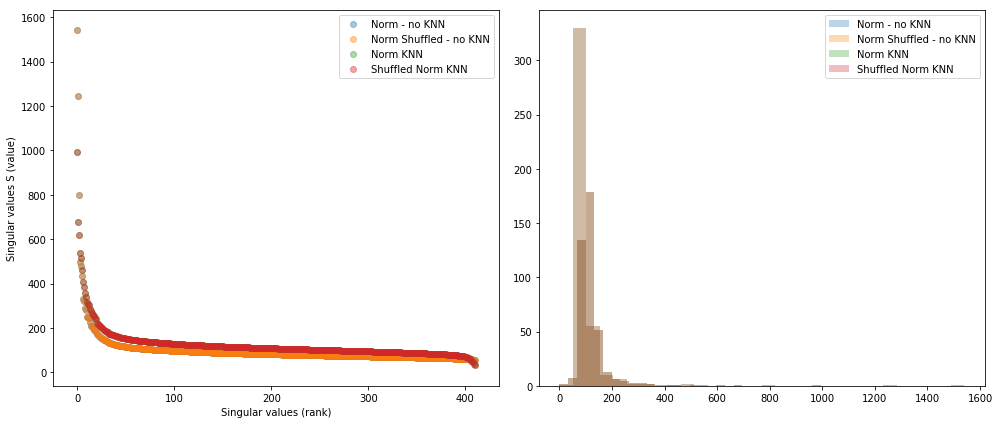

In [45]:
import random

def tejaas_rr(myGT, myGX, sigmax2, sb2):
    nsnps  = myGT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    for j in range(nsnps):       
        S2mod = S2 + (sigmax2[j] / sb2[j])
        Keff[j] = np.sum(S2/S2mod)
        
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
        Rscore[j] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(myGT[j, :].reshape(1, -1), Rscore[j], W)
        
#         rand_gt = copy.deepcopy(myGT[j,:])
#         emp_q = np.zeros(2000)
#         for k in range(2000):
#             random.shuffle(rand_gt)
#             emp_q[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2[j]
#         EmuQ[j]     = np.mean(emp_q)
#         EsigmaQ[j]  = np.var(emp_q)
        
        
    return S2, pvals, Rscore, muQ, sigmaQ, Keff #, EmuQ, EsigmaQ

def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2, sb2 = None, cismasks = None):
        
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
        
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = label, alpha=0.4)
    ax2.hist(S, bins=30, alpha=0.3, label = label)
    
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
            _s2, _pvals, _qscores, _muq, _sigmaq, _keff = tejaas_rr(myGT, myGX, sigmax2[cismask.apply2], sb2)
            pvals[cismask.apply2]  = _pvals
            Rscore[cismask.apply2] = _qscores
            muQ[cismask.apply2]    = _muq
            sigmaQ[cismask.apply2] = _sigmaq
            Keff[cismask.apply2]   = _keff
            
    else:
        S2, pvals, Rscore, muQ, sigmaQ = tejaas_rr(myGT, myGX, sigmax2, sb2)        
    return S2, pvals, Rscore, muQ, sigmaQ, opt_sb2, Keff #, EmuQ, EsigmaQ

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sb  = 0.01
sb2 = np.repeat(sb*sb, gt_cent.shape[0])

# - No KNN
nS2, npvals, nQ, nmuQ, nscaledQ, nopt_sb2, nKeff = compare_basic_props(gx_norm, 
                                                                       gt_cent, 
                                                                       ax1, ax2, 
                                                                       'Norm - no KNN', 
                                                                       sigmax2, 
                                                                       sb2 = sb2, 
                                                                       cismasks=cismaskcomp)
shuf_nS2, shuf_npvals, shuf_nQ, shuf_nmuQ, shuf_nscaledQ, shuf_nopt_sb2, shuf_nKeff = compare_basic_props(gx_shuffled_norm, 
                                                                                                          gt_cent, 
                                                                                                          ax1, ax2, 
                                                                                                          'Norm Shuffled - no KNN', 
                                                                                                          sigmax2, 
                                                                                                          sb2 = sb2, 
                                                                                                          cismasks=cismaskcomp)

S2, pvals, Q, muQ, scaledQ, opt_sb2, Keff = compare_basic_props(gx_knn_norm, 
                                                                gt_knn_cent, 
                                                                ax1, ax2, 
                                                                'Norm KNN', 
                                                                sigmax2_knn, 
                                                                sb2 = sb2, 
                                                                cismasks=cismaskcomp)
shuf_S2, shuf_pvals, shuf_Q, shuf_muQ, shuf_scaledQ, shuf_opt_sb2, shuf_Keff = compare_basic_props(gx_shuffled_knn_norm, 
                                                                                                   gt_knn_cent, 
                                                                                                   ax1, ax2, 
                                                                                                   'Shuffled Norm KNN', 
                                                                                                   sigmax2_knn, 
                                                                                                   sb2 = sb2, 
                                                                                                   cismasks=cismaskcomp)

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()

ax2.legend()
plt.tight_layout()
plt.show()


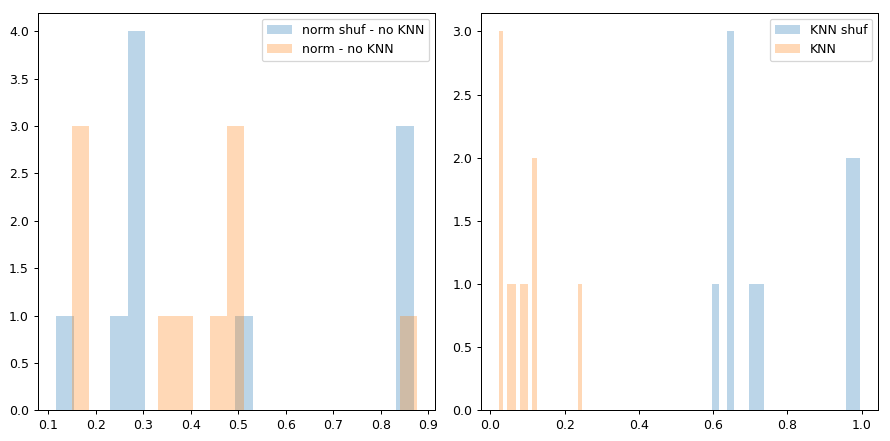

In [46]:
fig = plt.figure(figsize=(10,5), dpi=90)
ax1 = fig.add_subplot(1,2,1)
ax1.hist(shuf_npvals, bins=20, alpha=0.3, label="norm shuf - no KNN")
ax1.hist(npvals, bins=20, alpha=0.3, label="norm - no KNN")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.hist(shuf_pvals, bins=20, alpha=0.3, label="KNN shuf")
ax2.hist(pvals, bins=20, alpha=0.3, label="KNN")
ax2.legend()

plt.tight_layout()
plt.show()


In [47]:
snp_info[1]

SnpInfo(chrom=10, varid='10:111613_C_T', bp_pos=111613, ref_allele='C', alt_allele='T', maf=0.9313919902912597)

In [48]:
for i in range(100):
    print(snp_info[i].varid, Q[i], pvals[i])

10:98481_A_C 395.6213730322882 0.09828639465573263
10:111613_C_T 375.50339195251627 0.11881636826029118
10:111955_A_G 375.2090215658467 0.12086923074063671
10:113224_T_C 375.18206789550567 0.023853361158541864
10:113934_A_C 365.2342799158546 0.06045195889386645
10:114779_C_T 373.1475378731863 0.023572908900899137
10:114926_G_A 377.37718933161716 0.055548788234116464
10:116256_G_T 378.09226965333124 0.08560948315895389
10:116433_C_A 360.22028856054203 0.24796331571970653
10:117211_T_C 371.6173553022765 0.02505295551985942


IndexError: list index out of range

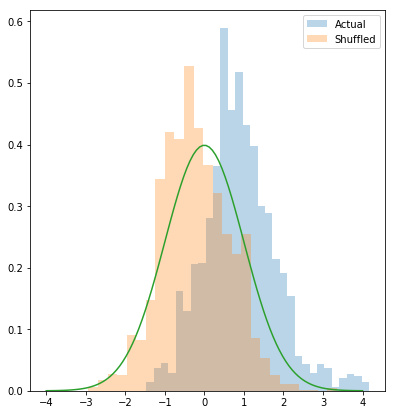

In [20]:
# - no KNN
qscaled = (nQ - nmuQ)/ nscaledQ
shuf_qscaled = (shuf_nQ - shuf_nmuQ)/ shuf_nscaledQ

# - KNN 30
qscaled = (Q - muQ)/ scaledQ
shuf_qscaled = (shuf_Q - shuf_muQ)/ shuf_scaledQ

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.hist(qscaled, bins=30, alpha=0.3, density=True, label="Actual")
ax1.hist(shuf_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")
ax1.legend()

# ax2 = fig.add_subplot(122)
# ax2.hist(qscaled2, bins=30, alpha=0.3, density=True, label="Actual")
# ax2.hist(shuf_qscaled2, bins=30, alpha=0.3, density=True, label="Shuffled")
# ax2.legend()

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')

plt.show()